# Comparative Analysis
In this notebook, we compare ClaP with segmentation competitors.

In [7]:
%load_ext autoreload
%autoreload 2
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

from aeon.visualisation import plot_critical_difference
from external.MCM import MCM
from wand.image import Image

sns.set_theme()
sns.set_color_codes()

import os
import sys

sys.path.append("../../")

Let's choose a score for evaluation (F1 or Covering).

In [9]:
eval_score = "covering_score"

Let's load the scores from the different methods.

In [10]:
c1 = ["BinSeg", "DDRE", "FLUSS", "Pelt", "RuLSIF", "Window", "ClaSP"]
c2 = ["AutoPlait", "CLaP", "HDP-HSMM", "TICC", "Time2State", "ClaSP2Feat"]

datasets = ["UTSA", "TSSB"]
methods, dfs = list(), list()

for candidate_name in c1:
    methods.append((candidate_name, "segmentation", f"{candidate_name}.csv.gz"))

for candidate_name in c2:
    methods.append((candidate_name, "state_detection", f"{candidate_name}.csv.gz"))

for idx, (name, comp_type, file_name) in enumerate(methods):
    df = []

    for d in datasets:
        df.append(pd.read_csv(f"../../experiments/{comp_type}/{d}_{file_name}", usecols=["dataset", eval_score],
                              compression="gzip"))

    df = pd.concat(df)
    df.sort_values(by="dataset", inplace=True)
    dfs.append((name, df))

df_scores = pd.DataFrame()

for name, df in dfs:
    df_scores["dataset"] = df.dataset
    df_scores[name] = df[eval_score]

df_scores.reset_index(drop=True, inplace=True)
df_scores

,dataset,BinSeg,DDRE,FLUSS,Pelt,RuLSIF,Window,ClaSP,AutoPlait,CLaP,HDP-HSMM,TICC,Time2State,ClaSP2Feat
0,Adiac,0.303,0.325,0.430,0.303,0.358,0.303,0.807,0.303,0.971,0.650,0.303,0.401,0.807
1,ArrowHead,0.500,0.219,0.995,0.500,0.199,0.500,0.985,0.500,0.985,0.664,0.472,0.699,0.985
2,Beef,0.500,0.678,0.935,0.500,0.633,0.500,0.973,0.491,0.973,0.675,0.471,0.328,0.973
3,BeetleFly,0.652,0.150,0.500,0.652,0.178,0.500,0.975,0.500,0.975,0.407,0.794,0.307,0.975
4,BirdChicken,0.500,0.258,0.500,0.500,0.280,0.500,0.994,0.500,0.994,0.409,0.731,0.401,0.994
5,CBF,0.342,0.537,0.861,0.342,0.621,0.342,0.979,0.342,0.979,0.601,0.496,0.644,0.979
6,Cane,0.937,0.517,0.741,0.937,0.413,0.935,0.778,0.507,0.778,0.213,0.337,0.141,0.778
7,Car,0.256,0.411,0.256,0.256,0.353,0.256,0.742,0.256,0.742,0.645,0.643,0.580,0.742
8,Chinatown,1.000,0.333,0.704,1.000,0.412,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
9,ChlorineConcentration,0.577,0.046,0.577,0.577,0.056,0.577,0.577,0.577,0.577,0.133,0.563,0.091,0.577


Let's calculate the mean/median/std score.

In [11]:
df_scores.iloc[:, 1:].mean(axis=0).sort_values(ascending=False).round(3)

CLaP          0.846
ClaSP         0.826
ClaSP2Feat    0.826
BinSeg        0.636
TICC          0.628
Pelt          0.615
FLUSS         0.570
Window        0.541
AutoPlait     0.478
Time2State    0.370
HDP-HSMM      0.358
RuLSIF        0.251
DDRE          0.243
dtype: float64

In [12]:
df_scores.iloc[:, 1:].median(axis=0).sort_values(ascending=False).round(3)

CLaP          0.930
ClaSP         0.922
ClaSP2Feat    0.922
TICC          0.607
BinSeg        0.603
Pelt          0.577
FLUSS         0.535
Window        0.501
AutoPlait     0.491
HDP-HSMM      0.338
Time2State    0.334
RuLSIF        0.204
DDRE          0.196
dtype: float64

In [13]:
df_scores.iloc[:, 1:].std(axis=0).sort_values().round(3)

RuLSIF        0.159
DDRE          0.162
CLaP          0.184
ClaSP         0.198
ClaSP2Feat    0.198
Time2State    0.219
TICC          0.232
Window        0.233
Pelt          0.241
HDP-HSMM      0.241
BinSeg        0.242
AutoPlait     0.254
FLUSS         0.254
dtype: float64

Let's compute the wins per method.

In [14]:
ranks = df_scores.iloc[:, 1:].rank(1, method='min', ascending=False)
means = np.array(ranks.mean(axis=0))
args = np.argsort(means)

In [15]:
for mean, name in zip(means[args], df_scores.columns[1:].to_numpy()[args]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 1)}")

CLaP:wins=58 rank=2.1
ClaSP:wins=53 rank=2.5
ClaSP2Feat:wins=53 rank=2.5
BinSeg:wins=20 rank=4.8
Pelt:wins=19 rank=5.2
TICC:wins=17 rank=5.8
Window:wins=10 rank=6.2
FLUSS:wins=11 rank=6.3
AutoPlait:wins=12 rank=7.4
HDP-HSMM:wins=3 rank=9.2
Time2State:wins=2 rank=9.2
RuLSIF:wins=0 rank=10.8
DDRE:wins=0 rank=11.0


Let's plot the CD diagram.

/Users/ermshaua/miniconda3/envs/clap/lib/python3.9/site-packages/aeon/visualisation/results/_critical_difference.py:217: UserWarning: Estimators ClaSP and ClaSP2Feat have the same performanceon all datasets. This may cause problems when forming cliques.
  p_values = wilcoxon_test(ordered_scores, ordered_labels, lower_better)


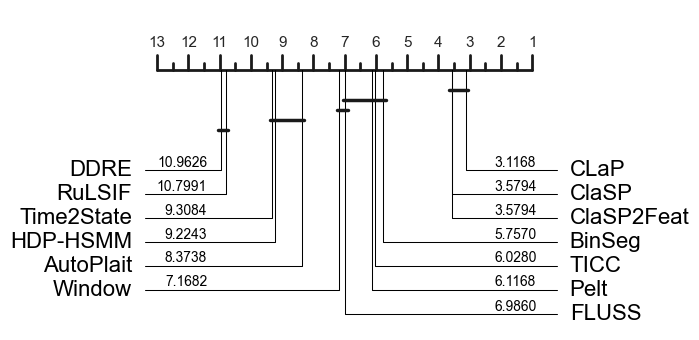

In [16]:
ax = plot_critical_difference(
    scores=df_scores.iloc[:, 1:].to_numpy(),
    labels=df_scores.columns[1:].to_numpy(),
    alpha=0.05,
)

plt.savefig("../../figures/cd_segmentation_comparative_combined.pdf", bbox_inches="tight")

 Let's plot the MCM.

In [17]:
dir_path = "../../figures/"
file_name = "mcm_segmentation_comparative_combined"

MCM.compare(
    output_dir=dir_path,
    used_statistic="Score",
    save_as_json=False,
    df_results=df_scores.iloc[:, 1:],
    pdf_savename=file_name,
    load_analysis=False,
    pvalue_correction="Holm",
    row_comparates=("CLaP",),
    fig_size=(20, 5),
    font_size=18,
    precision=3
)
Image(filename=os.path.join(dir_path, file_name + ".pdf"))

Processing ClaSP, ClaSP2Feat:   0%|          | 0/13 [00:00<?, ?it/s] 

ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

Let's compute wins/losses against CLaP.

In [18]:
selection = "CLaP"

for rival in df_scores.columns[1:]:
    if rival == selection: continue

    df_pair = df_scores[[selection, rival]]
    pair_ranks = df_pair.rank(1, method='min', ascending=False)

    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]

    assert wins + losses + ties == pair_ranks.shape[0]

    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

CLaP vs BinSeg: (wins/ties/losses): 73/8/26
CLaP vs DDRE: (wins/ties/losses): 106/0/1
CLaP vs FLUSS: (wins/ties/losses): 86/11/10
CLaP vs Pelt: (wins/ties/losses): 79/7/21
CLaP vs RuLSIF: (wins/ties/losses): 107/0/0
CLaP vs Window: (wins/ties/losses): 84/9/14
CLaP vs ClaSP: (wins/ties/losses): 24/76/7
CLaP vs AutoPlait: (wins/ties/losses): 88/13/6
CLaP vs HDP-HSMM: (wins/ties/losses): 102/1/4
CLaP vs TICC: (wins/ties/losses): 80/6/21
CLaP vs Time2State: (wins/ties/losses): 100/2/5
CLaP vs ClaSP2Feat: (wins/ties/losses): 24/76/7


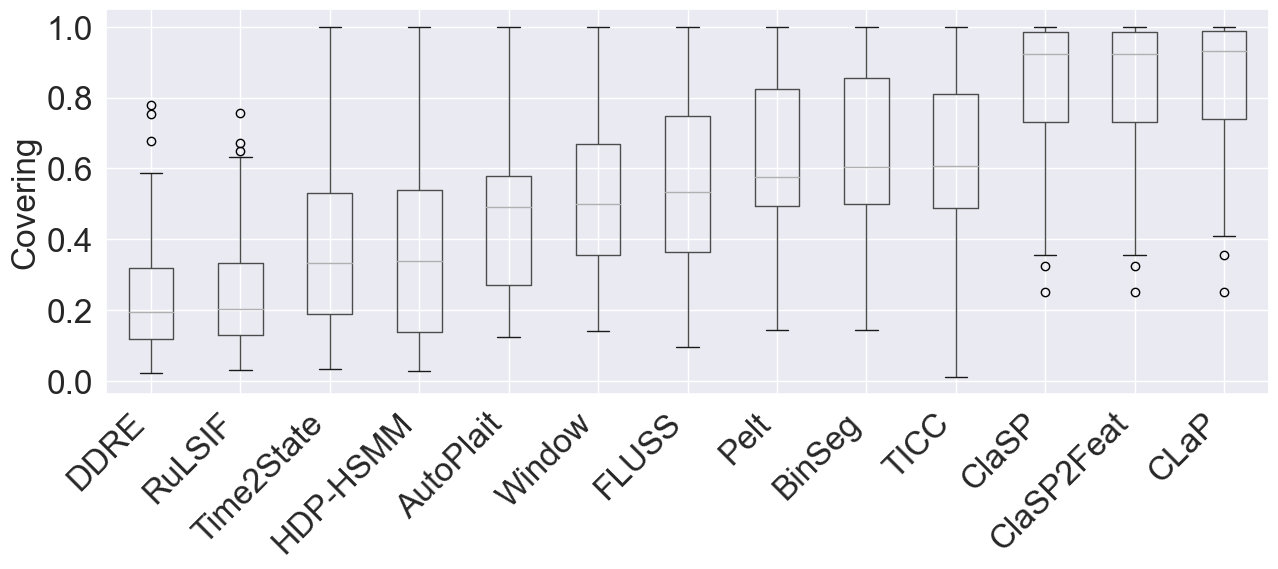

In [19]:
fontsize = 24
_, ax = plt.subplots(figsize=(15, 5))

# Sort by median performance
df_sorted_scores = df_scores[df_scores.iloc[:, 1:].median(axis=0).sort_values().index]

df_sorted_scores.boxplot(ax=ax, rot=90)
ax.set_ylabel("Covering", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xticklabels(df_sorted_scores.columns, rotation=45, ha="right")
ax.set_yticks(np.round(np.arange(0, 1.0 + .2, .2), 1))

plt.savefig(f"../../figures/bp_segmentation_comparative_combined.pdf", bbox_inches="tight")